# PrimoRL Trading Analysis

This notebook provides detailed analysis of PrimoRL trading performance with NLP features:

## Features
1. Cumulative return comparison:
   - PrimoRL strategy (with NLP features)
   - Buy & Hold benchmark
2. Trade visualization:
   - Buy points (green triangles ▲)
   - Sell points (red triangles ▼)
3. Volume analysis:
   - Trade volume in separate panel
   - Color-coded buy/sell volumes

## Data Sources
- PrimoRL account value (`{symbol}_primorl_df_account_value_ppo.pkl`)
- Trading actions (`{symbol}_primorl_df_actions_ppo.pkl`)
- Buy & Hold data (`{symbol}_primorl_buy_and_hold.pkl`)

In [1]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
import pickle

### Loading Data

In [2]:
# Load account value data
with open('crm_primorl_df_account_value_ppo.pkl', 'rb') as f:
    df_account_value = pickle.load(f)

# Load trading actions data
with open('crm_primorl_df_actions_ppo.pkl', 'rb') as f:
    df_actions = pickle.load(f)

# Load buy and hold data
with open('crm_primorl_buy_and_hold.pkl', 'rb') as f:
    buy_and_hold = pickle.load(f)

### Plot agent and buy & hold graph with buy/sell points

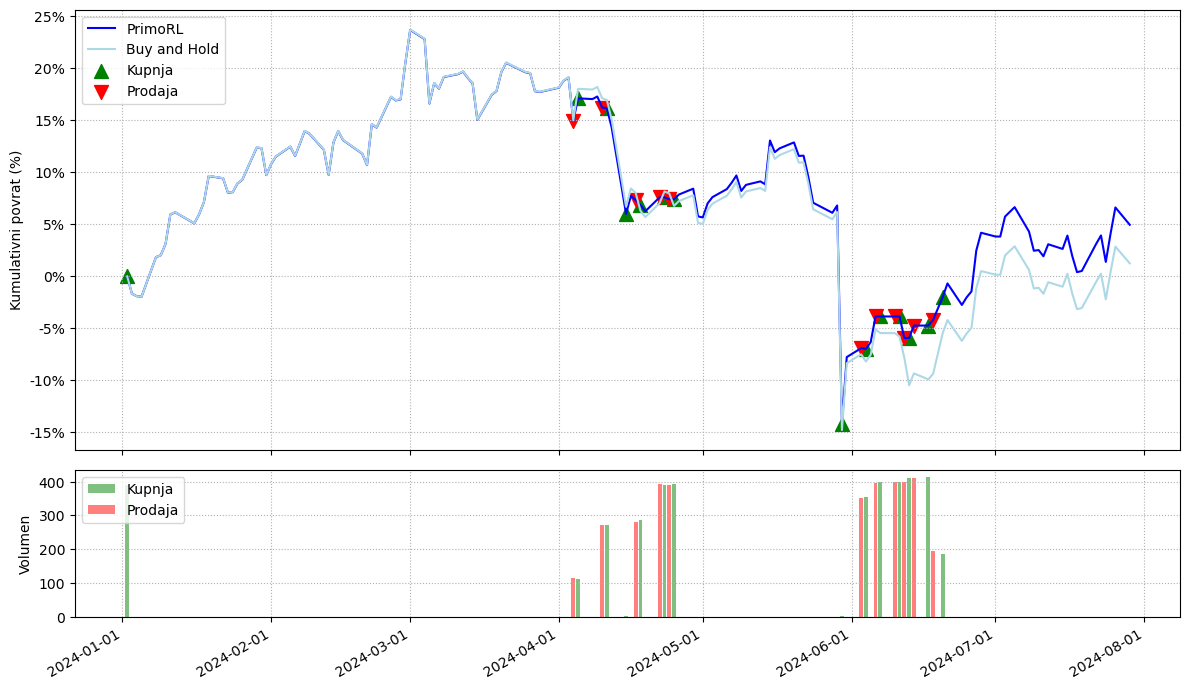

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Prepare data
df = df_account_value.copy()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Calculate cumulative return for PPO and Buy & Hold
initial_value_ppo = df['account_value'].iloc[0]
df['cumulative_return'] = (df['account_value'] / initial_value_ppo - 1) * 100

buy_and_hold.index = pd.to_datetime(buy_and_hold.index)
buy_and_hold = buy_and_hold.reindex(df.index).ffill()
initial_value_bh = buy_and_hold['close'].iloc[0]
buy_and_hold['cumulative_return'] = (buy_and_hold['close'] / initial_value_bh - 1) * 100

# Prepare buy and sell points data
buys = df_actions[df_actions['actions'].apply(lambda x: x[0] > 0)]
sells = df_actions[df_actions['actions'].apply(lambda x: x[0] < 0)]

# Create plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# Plot main lines
ax1.plot(df.index, df['cumulative_return'], color='blue', label='PrimoRL')
ax1.plot(buy_and_hold.index, buy_and_hold['cumulative_return'], color='lightblue', label='Buy and Hold')

# Add buy/sell points
ax1.scatter(buys.index, df.loc[buys.index, 'cumulative_return'], color='green', marker='^', s=100, label='Kupnja')
ax1.scatter(sells.index, df.loc[sells.index, 'cumulative_return'], color='red', marker='v', s=100, label='Prodaja')

# Format y-axis to show percentages without decimals
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x)}%'))

# Add legend
ax1.legend(loc='upper left')

# Set title and axis labels
ax1.set_ylabel('Kumulativni povrat (%)')

# Plot volume
ax2.bar(buys.index, buys['actions'].apply(lambda x: abs(x[0])), color='green', alpha=0.5, label='Kupnja')
ax2.bar(sells.index, sells['actions'].apply(lambda x: abs(x[0])), color='red', alpha=0.5, label='Prodaja')

ax2.set_ylabel('Volumen')
ax2.legend(loc='upper left')

# Format x-axis
plt.gcf().autofmt_xdate()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.tight_layout()
plt.show()